In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from scipy.stats import expon, multivariate_normal, norm


# Question 1

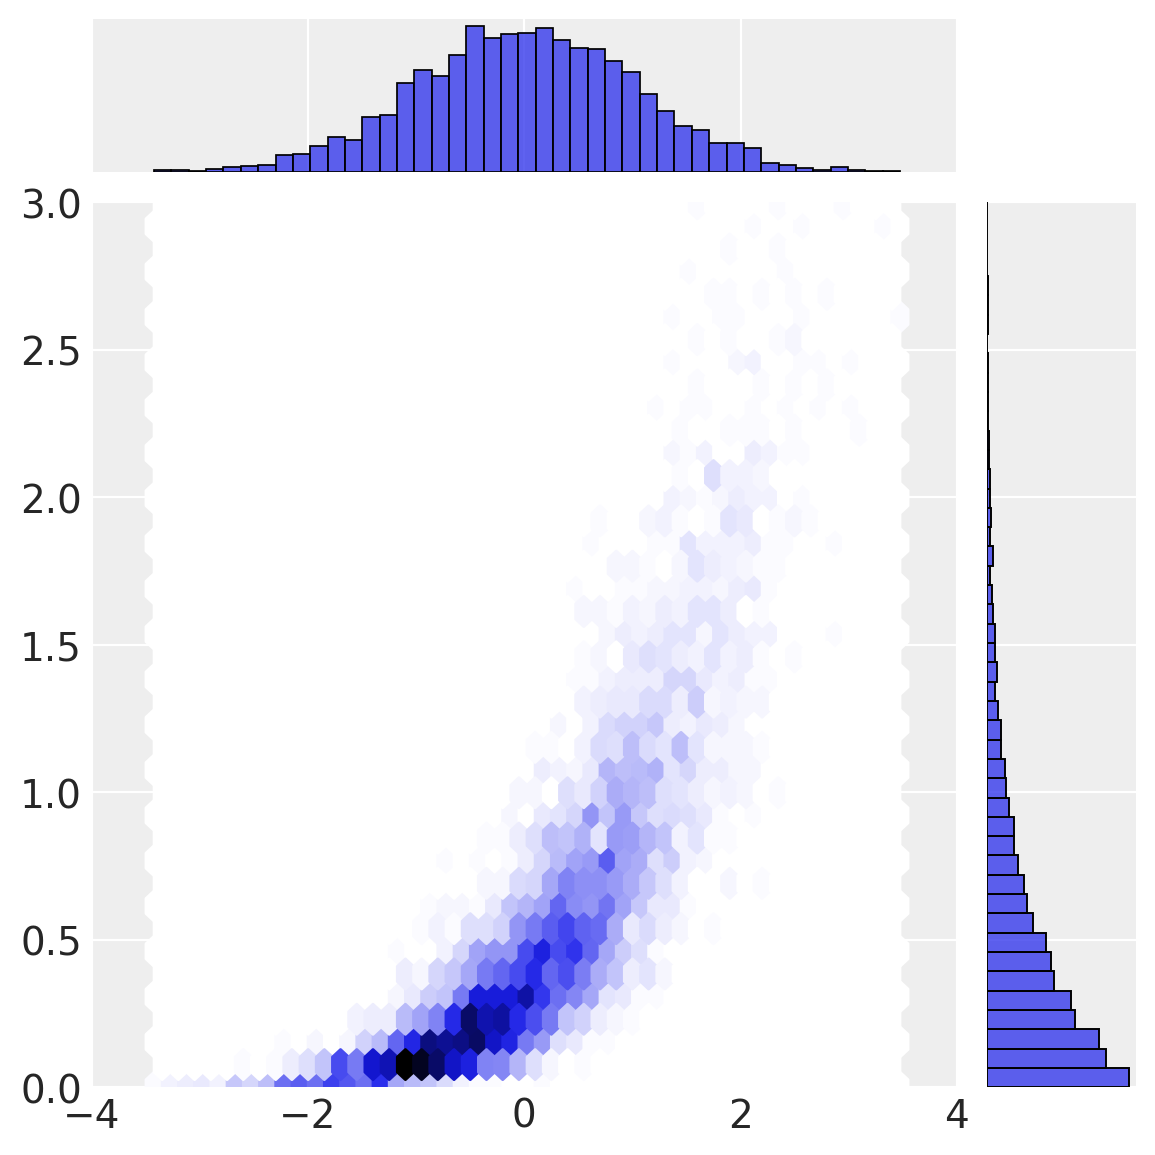

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
plt.rcParams.update({"font.size": 14, "figure.constrained_layout.use": False})
SEED = 43
rng = np.random.default_rng(SEED)

# Data Generation: Create synthetic data via a copula
b_scale_true = 2
true_params = {"a_dist": norm(), "b_dist": expon(scale=1 / b_scale_true), "rho": 0.9}
n_samples = 5000

# Draw samples in latent (bivariate normal) space
mu = [0, 0]
cov_true = [[1, true_params["rho"]], [true_params["rho"], 1]]
latent_samples = multivariate_normal(mu, cov_true).rvs(n_samples, random_state=rng)
a_norm = latent_samples[:, 0]
b_norm = latent_samples[:, 1]

# Transform latent normal samples to uniform via the normal CDF
a_unif = norm().cdf(a_norm)
b_unif = norm().cdf(b_norm)

# Transform uniforms to observation space using the true marginal quantile functions
a_obs = true_params["a_dist"].ppf(a_unif)
b_obs = true_params["b_dist"].ppf(b_unif)

sns.jointplot(x=a_obs, y=b_obs, height=6, kind="hex", xlim=(-4, 4), ylim=(0, 3))
plt.show()


In [3]:
# First Pass: Marginal Estimation
coords = {"obs_id": np.arange(len(a_obs))}
with pm.Model(coords=coords) as marginal_model:
    # Marginal for variable a (assumed Normal)
    a_mu = pm.Normal("a_mu", mu=0, sigma=1)
    a_sigma = pm.Exponential("a_sigma", lam=0.5)
    pm.Normal("a", mu=a_mu, sigma=a_sigma, observed=a_obs, dims="obs_id")

    # Marginal for variable b (assumed Exponential)
    b_scale = pm.Exponential("b_scale", lam=0.5)
    pm.Exponential("b", lam=1 / b_scale, observed=b_obs, dims="obs_id")

    marginal_trace = pm.sample(random_seed=rng)

# Extract point estimates (here we take the posterior mean) for use in the transformation
a_mu_est = marginal_trace.posterior["a_mu"].mean().item()
a_sigma_est = marginal_trace.posterior["a_sigma"].mean().item()
b_scale_est = marginal_trace.posterior["b_scale"].mean().item()

Output()

In [4]:
# Data Transformation for Copula Fitting

# Transform observations into the unit interval using the estimated marginals:
a_unif_est = norm(loc=a_mu_est, scale=a_sigma_est).cdf(a_obs)
b_unif_est = expon(scale=b_scale_est).cdf(b_obs)
# Then transform uniforms to the latent Gaussian space (via the probit, i.e. inverse CDF of the standard normal)
a_latent = norm().ppf(a_unif_est)
b_latent = norm().ppf(b_unif_est)
# Stack into an (n_samples x 2) array for the copula model
data_transformed = np.column_stack([a_latent, b_latent])

In [5]:
# Second Pass: Copula Estimation
# Extend coordinates to include parameter dimensions
coords.update({"param": ["a", "b"], "param_bis": ["a", "b"]})
with pm.Model(coords=coords) as copula_model:
    # Prior on the Cholesky factor of a 2D covariance matrix using an LKJ prior
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )
    cov_matrix = pm.Deterministic("cov", chol.dot(chol.T), dims=("param", "param_bis"))

    # Likelihood for the transformed data (latent space)
    pm.MvNormal("latent", mu=np.zeros(2), cov=cov_matrix,
                observed=data_transformed, dims=("obs_id", "param"))

    copula_trace = pm.sample(random_seed=rng)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

In [6]:
cov_post_mean = copula_trace.posterior["cov"].mean(dim=["chain", "draw"]).values

# Draw new latent samples using the estimated covariance
n_ppc_samples = 1000
latent_ppc = multivariate_normal(mean=[0, 0], cov=cov_post_mean).rvs(n_ppc_samples, random_state=rng)
# Transform latent samples to the uniform scale
u_ppc = norm().cdf(latent_ppc)
# Transform uniforms to observation space using the estimated marginal parameters
ppc_a = norm(loc=a_mu_est, scale=a_sigma_est).ppf(u_ppc[:, 0])
ppc_b = expon(scale=b_scale_est).ppf(u_ppc[:, 1])

/usr/local/lib/python3.11/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax.contour(x_x, y_y, density, **contour_kwargs)


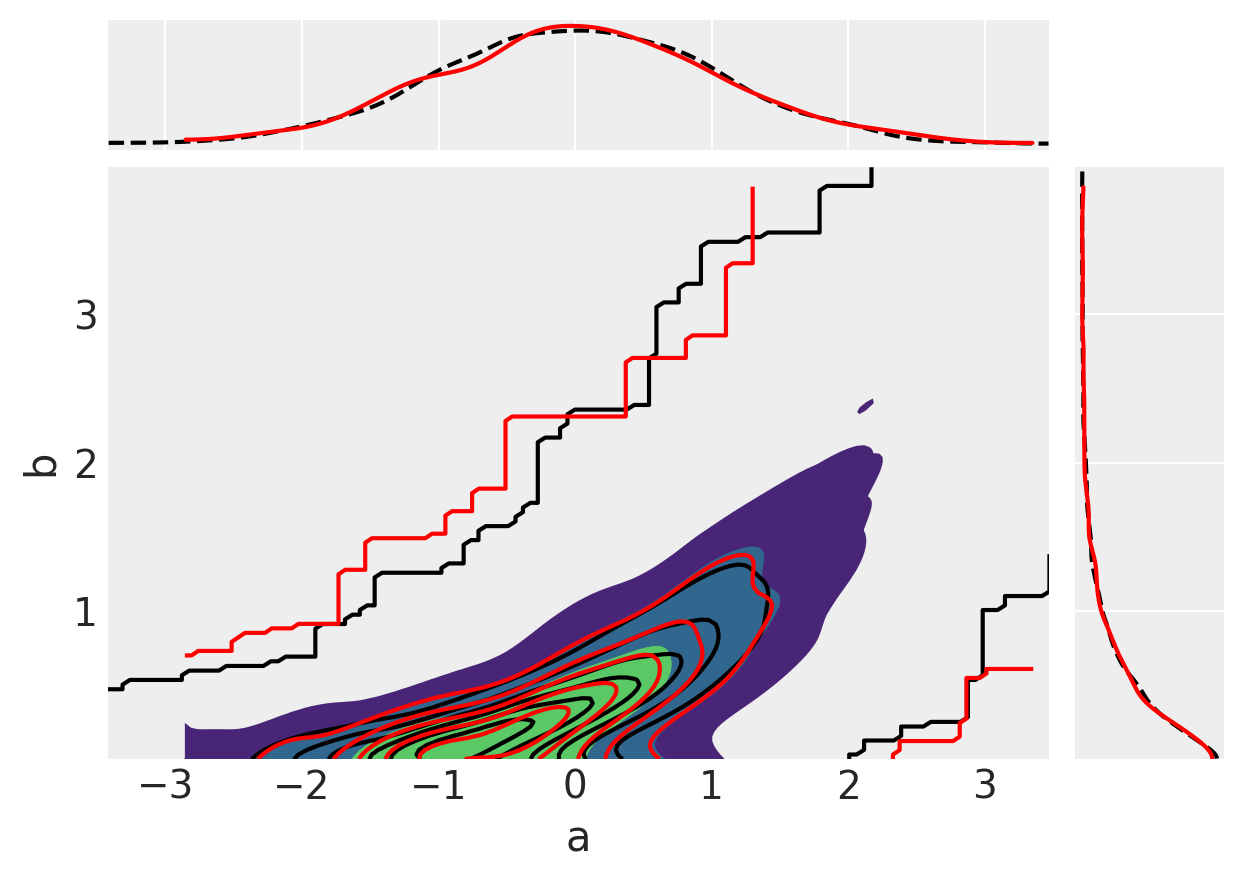

In [7]:
ax = az.plot_pair(
    {"a": a_obs, "b": b_obs},
    marginals=True,
    kind="kde",
    scatter_kwargs={"alpha": 0.1},
    kde_kwargs=dict(contour_kwargs=dict(colors="k", linestyles="--"),
                    contourf_kwargs=dict(alpha=0)),
    marginal_kwargs=dict(color="k", plot_kwargs=dict(ls="--")),
)
# Overlay PPC samples (red)
_ = az.plot_pair(
    {"a": ppc_a, "b": ppc_b},
    marginals=True,
    kind="kde",
    scatter_kwargs={"alpha": 0.1},
    kde_kwargs=dict(contour_kwargs=dict(colors="r", linestyles="-"),
                    contourf_kwargs=dict(alpha=0)),
    marginal_kwargs=dict(color="r"),
    ax=ax,
)
plt.show()

Copula allows us to model the dependence structure between random variables separately from their marginal distribution. This is useful when maginal behaviors are modeled by idfferent distributions, but you want to capture the joint behavior among the variables.

There are two ways to implement copula.

1. **one-pass approach**:
Marginal distributions and copula are estimated within single model. Marginal likelihoods are modeled with its own likelihood and use uniform transformation on observed data to isolate marginal bahvior. Then a multivariate normal model is used to model the joint dependence.


2. **two-pass approach**:
This approach decouples the estimation of the marginal distributions from the estimation of the copula. The first pass estimates the marginal by fitting separate models for each variable. Then use the fitted models to convert the observed data into uniform values. Then convert it to laten space to be fitted into a second model (second-pass) to estimate dependecy structure.


We can build a multivariate GLM regression that maintains the interpretability of individual GLM coefficients while accounting for dependencies between outcomes. We can use two-way approach to fit each marginal GLM, then transform to observed data to a uniform scale and map it to latent Gaussian space. Then we can remodel the joint dependence to benefit the both interpretability of individual marginal and joint dependent structure.

# Question 2

In [8]:
# Suppose we have data: X is (n x p), Y is (n x m).

np.random.seed(42)

n = 100   # number of observations
p = 20    # number of predictors

# Generate design matrix X (n x p)
X = np.random.randn(n, p)

# True sparse coefficients:
beta_true = np.zeros(p)

# Generate response y = X * beta_true + noise
noise_std = 0.5
Y = X @ beta_true + np.random.normal(loc=0.0, scale=noise_std, size=n)


with pm.Model() as spike_slab_model:

    # Prior on the probability of a predictor being "included"
    pi = pm.Beta('pi', alpha=1, beta=1)

    # For each predictor j=1...p:
    #  1) A binary indicator gamma_j
    #  2) The slab coefficient
    #  3) Combine them to get the actual regression coefficient

    gamma = pm.Bernoulli('gamma', p=pi, shape=p)  # shape p => array of indicators

    # "Slab" prior for each predictor's coefficient
    slab_scale = 10.0  # or some large scale
    slab_coeff = pm.Normal('slab_coeff',
                           mu=0, sigma=slab_scale,
                           shape=p)

    # "Spike" prior effectively a near-zero scale
    spike_scale = 0.001
    spike_coeff = pm.Normal('spike_coeff',
                            mu=0, sigma=spike_scale,
                            shape=p)

    beta = pm.Deterministic('beta', gamma * slab_coeff + (1 - gamma) * spike_coeff)

    mu = pm.math.dot(X, beta)
    sigma = pm.HalfCauchy('sigma', beta=1)

    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=Y)

    trace = pm.sample()


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
# Compare to a more "diffuse" prior model:
with pm.Model() as diffuse_model:

    beta_diffuse = pm.Normal('beta_diffuse', mu=0, sigma=3, shape=p)
    sigma_diffuse = pm.HalfCauchy('sigma', beta=1)
    mu_diffuse = pm.math.dot(X, beta_diffuse)

    y_obs_diffuse = pm.Normal('y_obs_diffuse',
                              mu=mu_diffuse,
                              sigma=sigma_diffuse,
                              observed=Y)

    trace_diffuse = pm.sample()


Output()

array([[<Axes: title={'center': 'beta_diffuse'}>,
        <Axes: title={'center': 'beta_diffuse'}>]], dtype=object)

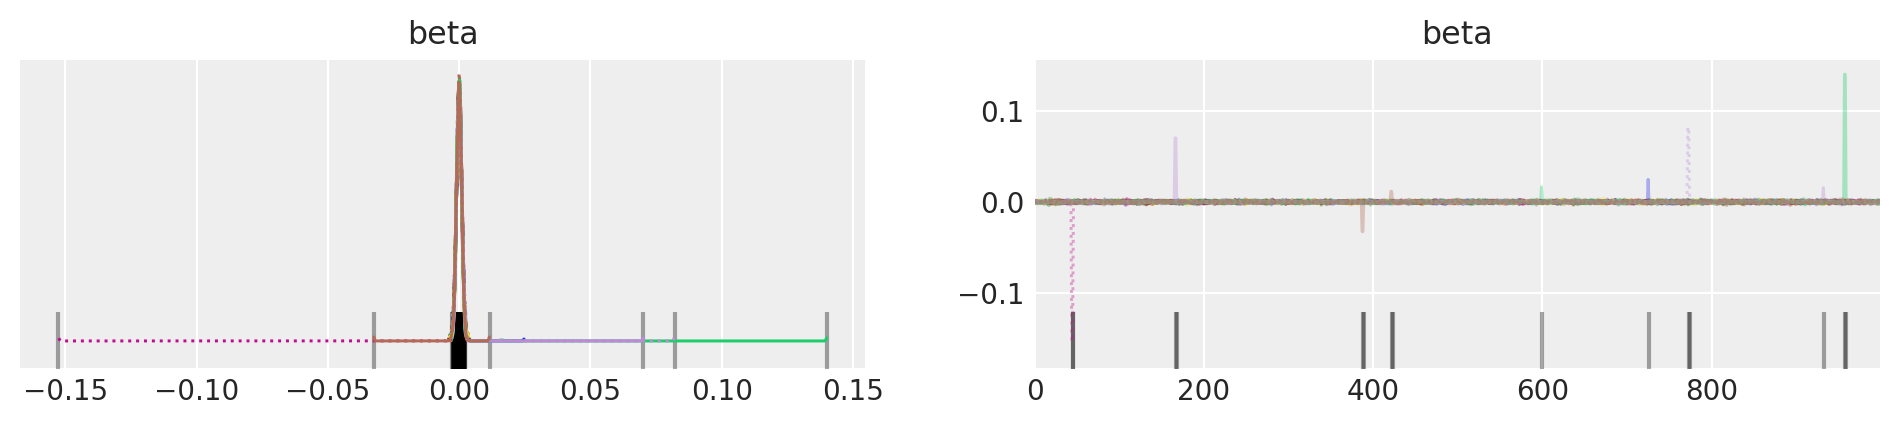

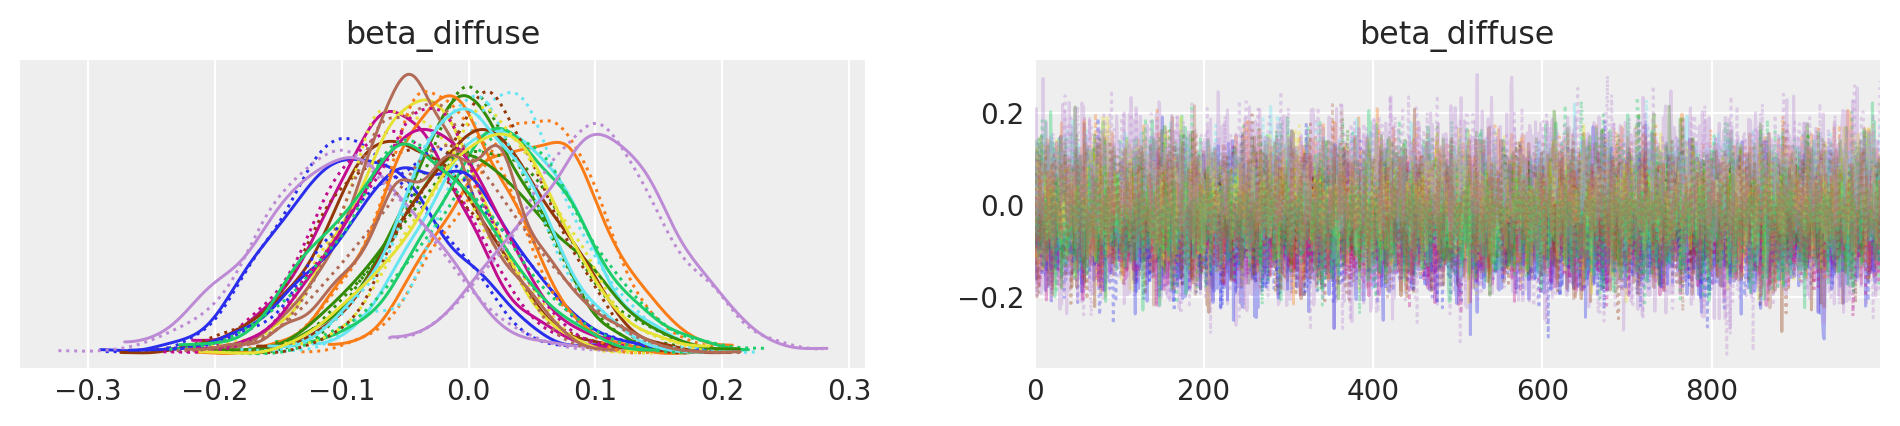

In [10]:
# Summaries of spike-and-slab coefficients
az.plot_trace(trace, var_names=['beta'])
az.plot_trace(trace_diffuse, var_names=['beta_diffuse'])

From the comparing posterior summaries of both models, we can see that spike-and-slab model shrinks unimportant coefficients closer to zero while the diffused prior may allow more spread. This shows that spike-and-slab is good for variable selection because it specifically models the possibility that many predictors have significant coefficients.

# Question 3

In [11]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

n = 100   # number of observations
p = 20    # number of predictors
m = 2     # number of output dimensions

# Design matrix X (n x p)
X = rng.normal(0, 1, size=(n, p))

# True sparse coefficients: shape (p, m)
beta_true = np.zeros((p, m))

# Noise standard deviations for each output dimension
noise_std = np.array([0.5, 1.0])  # shape (m,)

# Generate Y (n x m)
Y = X @ beta_true + rng.normal(0.0, noise_std, size=(n, m))


In [12]:
with pm.Model() as horseshoe_mv_model:
    # 1) Global shrinkage parameter
    tau = pm.HalfCauchy('tau', beta=1.0)

    # 2) Local shrinkage parameters for each predictor j=1..p
    lam = pm.HalfCauchy('lam', beta=1.0, shape=p)

    # 3) Horseshoe prior for coefficients: shape (p, m)
    #    The standard deviation for beta_{j,k} is tau * lam[j].
    #    We use broadcasting: lam[:, None] has shape (p, 1) -> (p, m)
    beta = pm.Normal('beta',
                     mu=0.0,
                     sigma=tau * lam[:, None],
                     shape=(p, m))

    # 4) Noise per output dimension
    sigma = pm.HalfCauchy('sigma', beta=1.0, shape=m)

    # 5) Likelihood for Y: shape (n, m)
    mu = pm.math.dot(X, beta)  # shape (n, m)

    # Assuming independence across columns, each column j has its own sigma[j]
    y_obs = pm.Normal('y_obs',
                      mu=mu,
                      sigma=sigma,
                      observed=Y)

    # Sample
    horseshoe_mv_trace = pm.sample(random_seed=42)


Output()

ERROR:pymc.stats.convergence:There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
with pm.Model() as spike_slab_mv_model:
    # Probability that a predictor is active
    pi = pm.Beta('pi', alpha=1, beta=1)
    gamma = pm.Bernoulli('gamma', p=pi, shape=p)

    slab_scale = 10.0
    slab_coeff = pm.Normal('slab_coeff', mu=0, sigma=slab_scale, shape=(p, m))

    spike_scale = 0.001
    spike_coeff = pm.Normal('spike_coeff', mu=0, sigma=spike_scale, shape=(p, m))

    # Combine them
    beta_ss = pm.Deterministic(
        'beta',
        gamma[:, None] * slab_coeff + (1 - gamma[:, None]) * spike_coeff
    )

    # Noise per dimension
    sigma_ss = pm.HalfCauchy('sigma', beta=1, shape=m)
    mu_ss = pm.math.dot(X, beta_ss)

    y_obs_ss = pm.Normal('y_obs', mu=mu_ss, sigma=sigma_ss, observed=Y)

    spike_slab_mv_trace = pm.sample(random_seed=42)


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


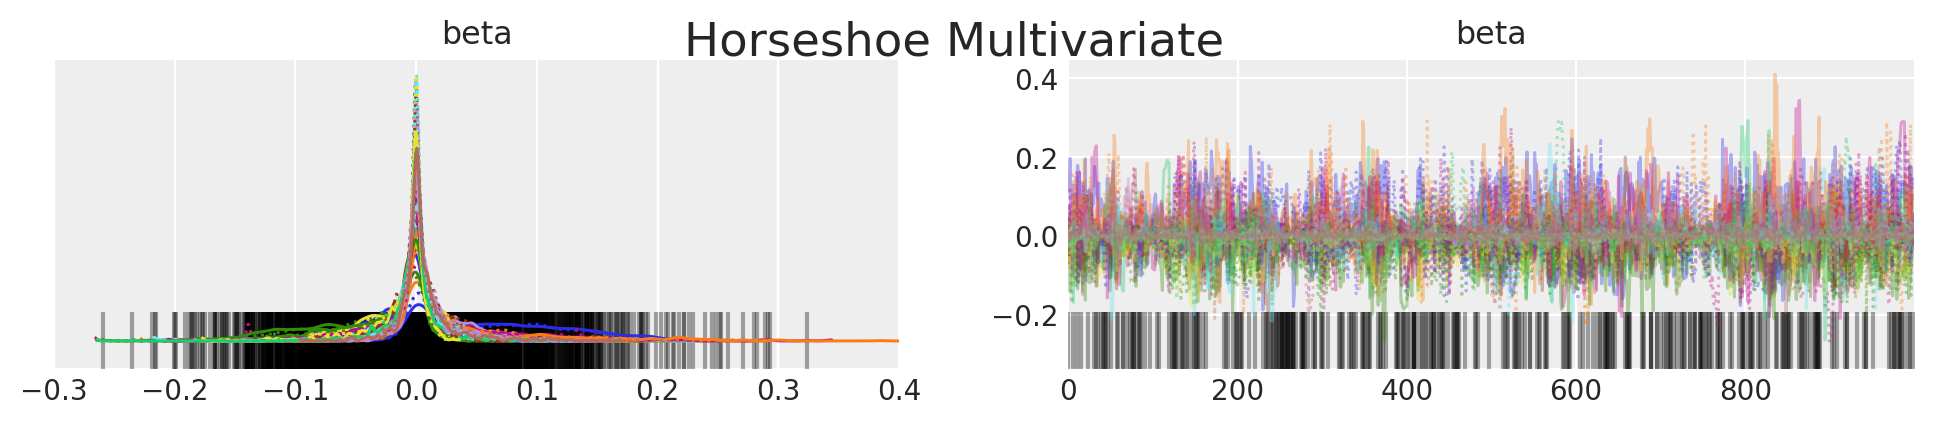

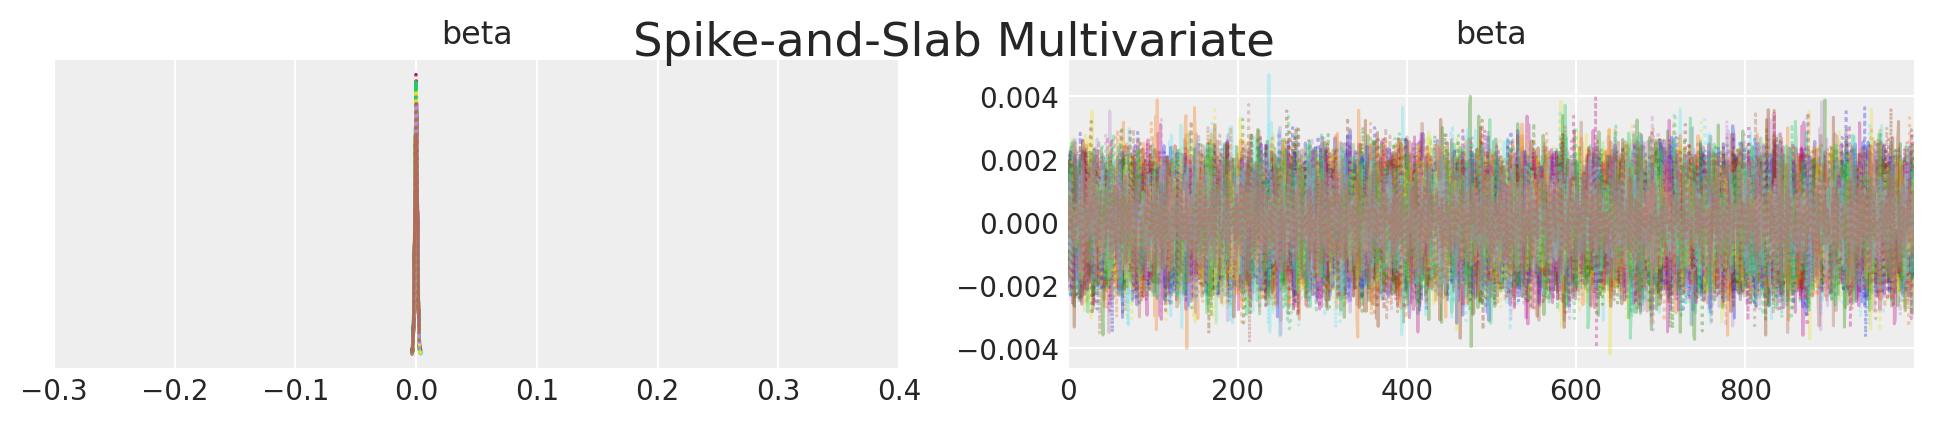

In [14]:
# First plot: Horseshoe
axes_hs = az.plot_trace(horseshoe_mv_trace, var_names=["beta"])
for i in range(axes_hs.shape[0]):
    axes_hs[i, 0].set_xlim(-0.3, 0.4)  # adjust as needed

plt.suptitle("Horseshoe Multivariate")
plt.show()

# Second plot: Spike-and-Slab
axes_ss = az.plot_trace(spike_slab_mv_trace, var_names=["beta"])
for i in range(axes_ss.shape[0]):
    axes_ss[i, 0].set_xlim(-0.3, 0.4)

plt.suptitle("Spike-and-Slab Multivariate")
plt.show()


1. Horseshoe

Many coefficients are heavily shrunk but not forced to exactly zero, indicating a continuous shrinkage. A stronger $\tau$ can push everything to zero like spike-and-slab, while $\lambda_i$ keeps the important predictors.

2. Spike-and-slab

Coefficients are either in a near-zero “spike” or a wider “slab". This can be more interpretable if we want explicit “included vs. excluded” variables.
